In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
import shutil
import time

(256, 256, 3)


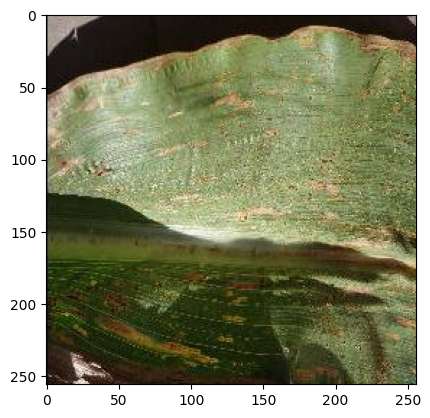

In [ ]:
fpath = '/content/sample_data/Plant/corn_cercospora_leaf/00120a18-ff90-46e4-92fb-2b7a10345bd3___RS_GLSp 9357_270deg.JPG'
img = plt.imread(fpath)
print (img.shape)
plt.imshow(img)

In [ ]:
sdir='/content/sample_data/Plant'
classlist=os.listdir(sdir)
filepaths=[]
labels=[]
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print('df length: ', len(df))
print (df['labels'].value_counts())

                                           filepaths            labels
0  /content/sample_data/Plant/corn_leaf_blight/54...  corn_leaf_blight
1  /content/sample_data/Plant/corn_leaf_blight/10...  corn_leaf_blight
2  /content/sample_data/Plant/corn_leaf_blight/7c...  corn_leaf_blight
3  /content/sample_data/Plant/corn_leaf_blight/78...  corn_leaf_blight
4  /content/sample_data/Plant/corn_leaf_blight/40...  corn_leaf_blight
df length:  5888
corn_cercospora_leaf    875
potato_early_blight     819
corn_leaf_blight        596
tomato_early_blight     581
tomato_healthy          567
corn_common_rust        542
tomato_late_blight      522
potato_healthy          518
corn_healthy            511
potato_late_blight      357
Name: labels, dtype: int64


In [ ]:
sample_list=[]
max_size= 500
groups=df.groupby('labels')
for label in df['labels'].unique():
    group=groups.get_group(label)
    sample_count=len(group)
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))
print (df['labels'].value_counts())

4857
corn_leaf_blight        500
tomato_healthy          500
corn_common_rust        500
corn_cercospora_leaf    500
potato_early_blight     500
potato_healthy          500
corn_healthy            500
tomato_early_blight     500
tomato_late_blight      500
potato_late_blight      357
Name: labels, dtype: int64


In [ ]:
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['corn_leaf_blight', 'tomato_healthy', 'corn_common_rust', 'corn_cercospora_leaf', 'potato_early_blight', 'potato_healthy', 'potato_late_blight', 'corn_healthy', 'tomato_early_blight', 'tomato_late_blight']


In [ ]:
target=500 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label
    sample_count=len(group)   # determine how many samples there are in this class
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)
            aug_img_count += len(images)

Found 357 validated image filenames.


In [ ]:
aug=r'./aug'
auglist=os.listdir(aug)
for klass in auglist:
    classpath=os.path.join(aug, klass)
    flist=os.listdir(classpath)
    print('klass: ', klass, '  file count: ', len(flist))

klass:  corn_leaf_blight   file count:  0
klass:  tomato_healthy   file count:  0
klass:  corn_common_rust   file count:  0
klass:  corn_cercospora_leaf   file count:  0
klass:  potato_early_blight   file count:  0
klass:  potato_healthy   file count:  0
klass:  potato_late_blight   file count:  143
klass:  corn_healthy   file count:  0
klass:  tomato_early_blight   file count:  0
klass:  tomato_late_blight   file count:  0


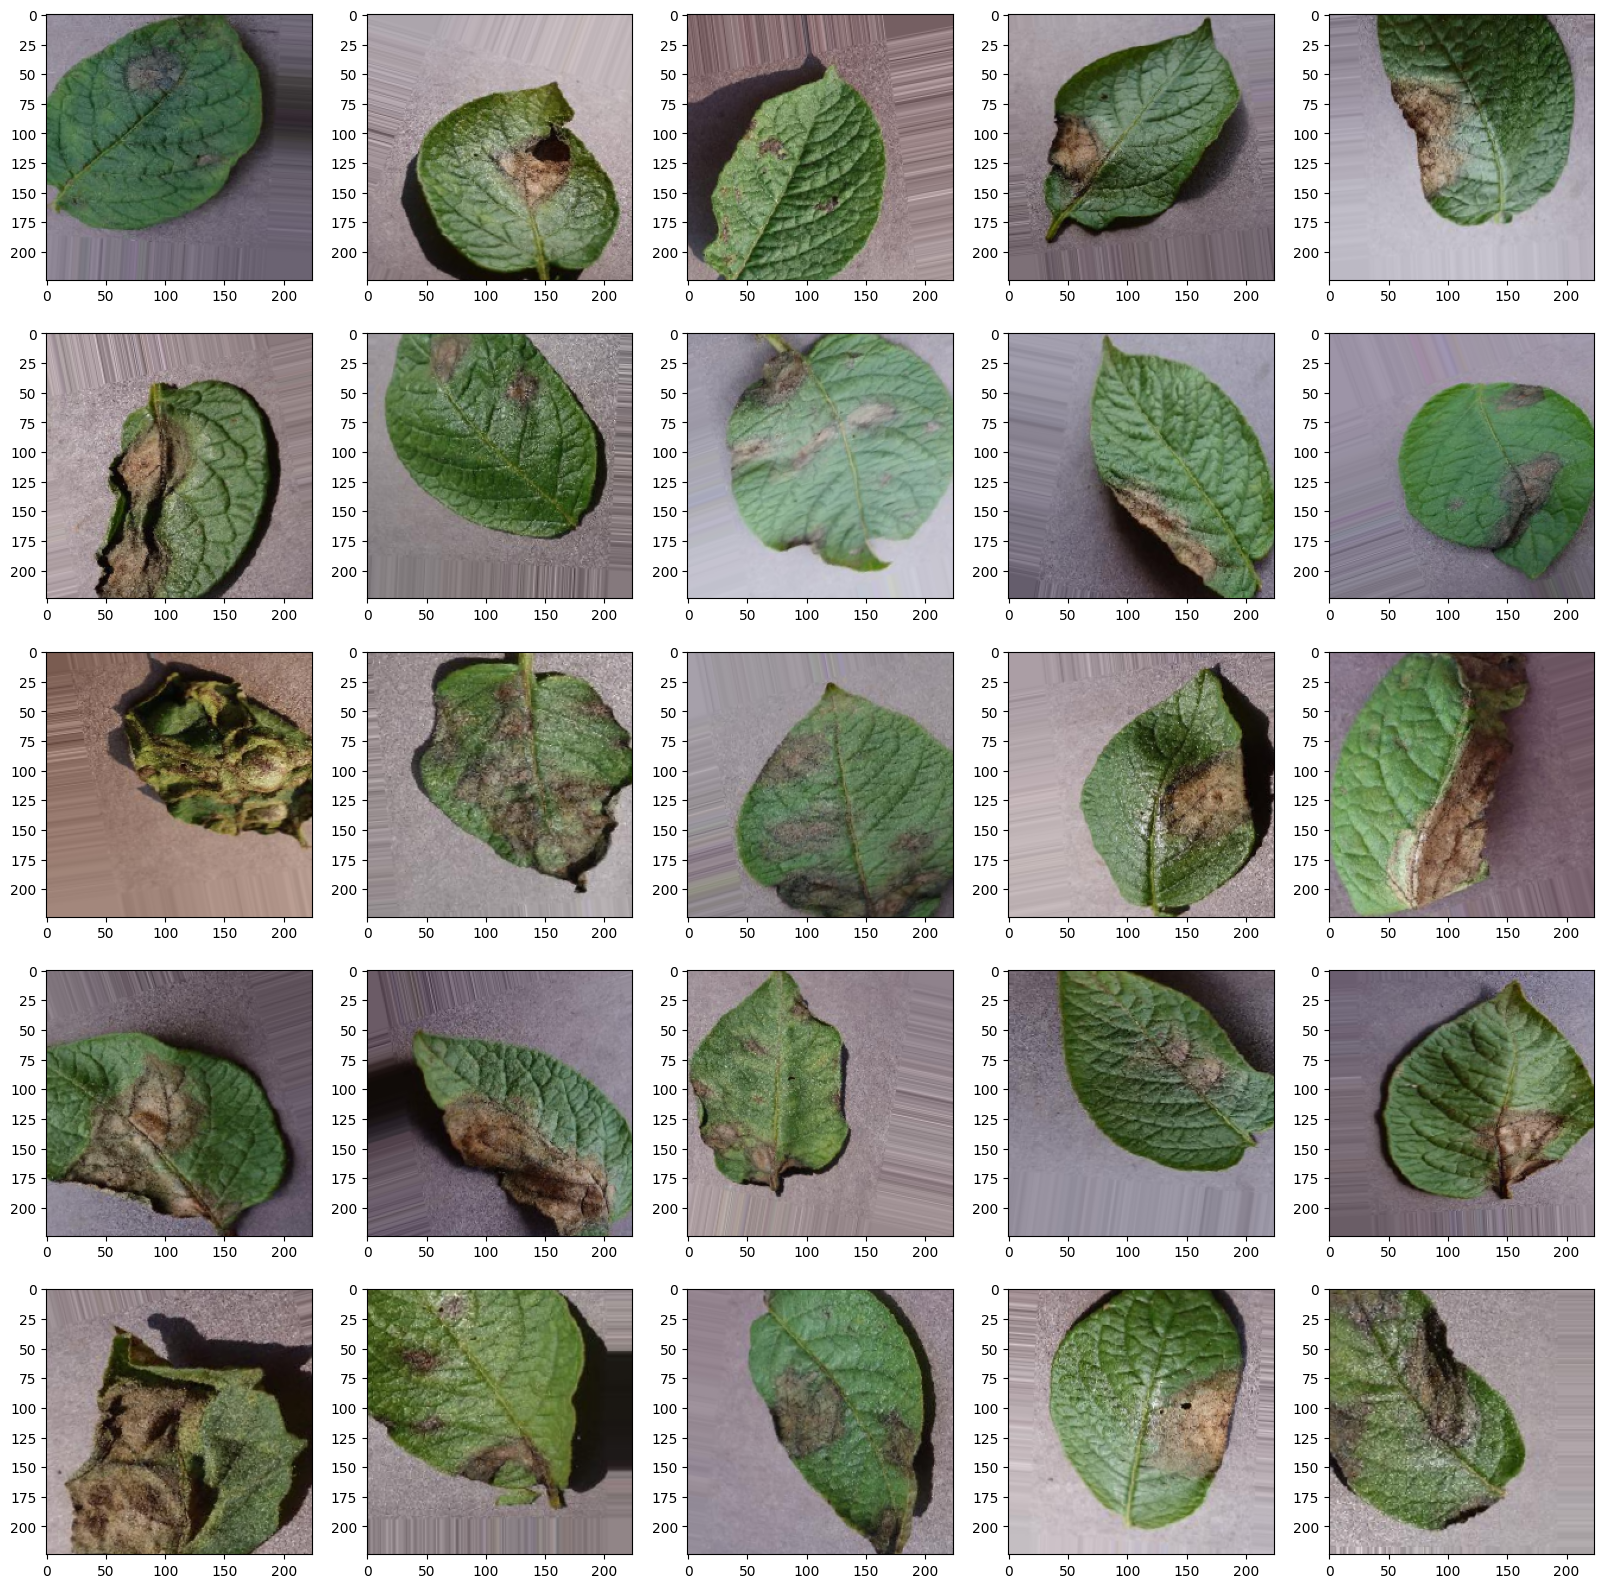

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(25):
    image=next(aug_gen)/255
    image=np.squeeze(image, axis=0)
    plt.subplot(5,5,i+1)
    plt.imshow(image)
plt.show()

In [ ]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
ndf=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
print (df['labels'].value_counts())
print(aug_df['labels'].value_counts())
print (ndf['labels'].value_counts())

corn_leaf_blight        500
tomato_healthy          500
corn_common_rust        500
corn_cercospora_leaf    500
potato_early_blight     500
potato_healthy          500
corn_healthy            500
tomato_early_blight     500
tomato_late_blight      500
potato_late_blight      357
Name: labels, dtype: int64
potato_late_blight    168
Name: labels, dtype: int64
potato_late_blight      525
corn_leaf_blight        500
tomato_healthy          500
corn_common_rust        500
potato_early_blight     500
corn_cercospora_leaf    500
potato_healthy          500
corn_healthy            500
tomato_early_blight     500
tomato_late_blight      500
Name: labels, dtype: int64


In [ ]:
train_split= 0.8
valid_split= 0.1
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(ndf, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  4020   test_df length:  503   valid_df length:  502


In [ ]:
height=256
width=256
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  1   test steps:  503
Found 4020 validated image filenames belonging to 10 classes.
Found 503 validated image filenames belonging to 10 classes.
Found 501 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, fontsize=10)
        plt.axis('off')
    plt.show()

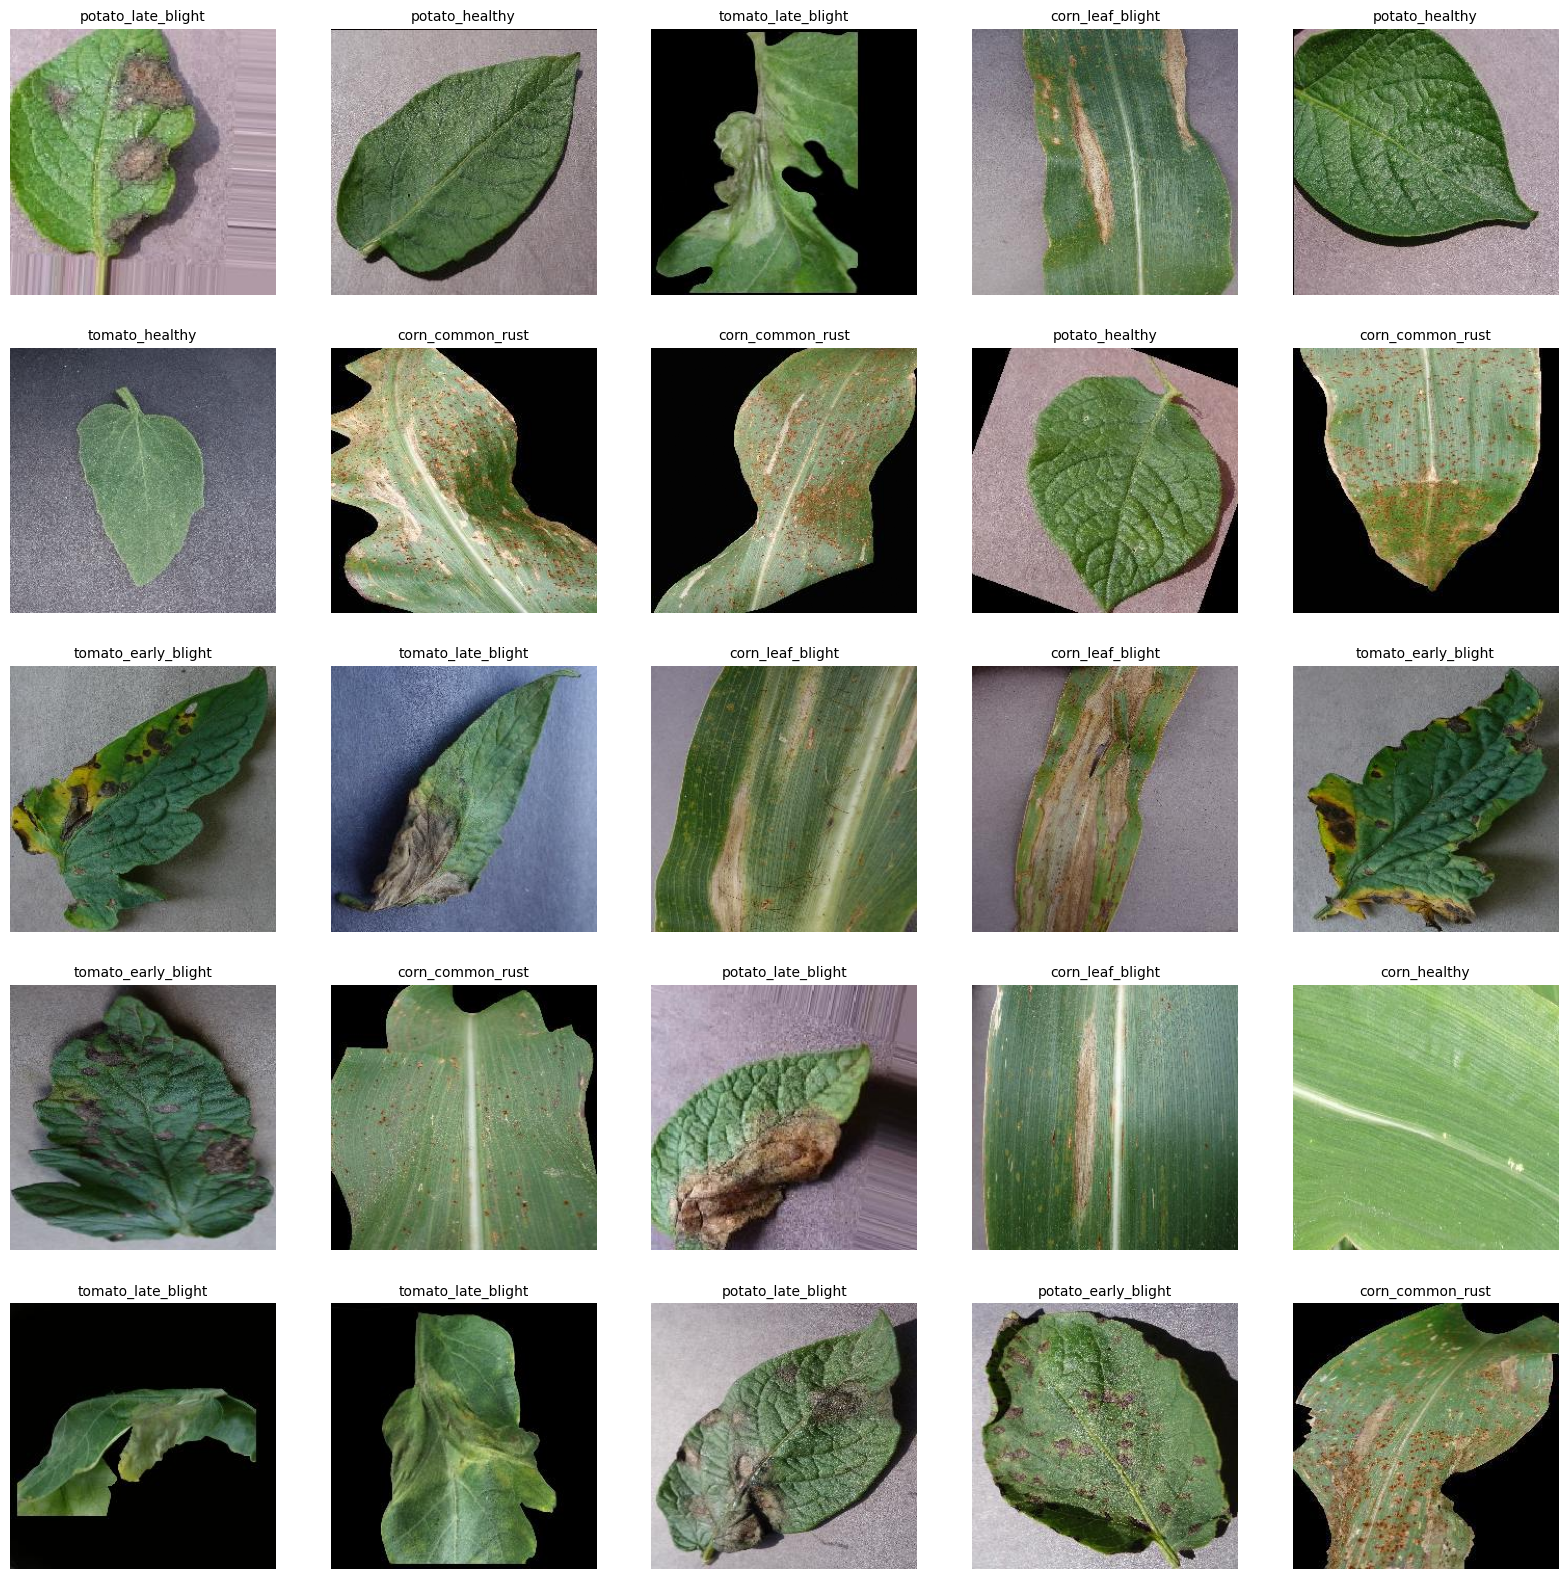

In [ ]:
show_image_samples(train_gen)

In [ ]:
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0

    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement
        self.initial_epoch=initial_epoch
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '
        print_in_color (msgs, (2255,255,255), (0,0,0))
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (255,255,255), (0,0,0))
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print_in_color(msg, (255,255,255), (0,0,0))

    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count


    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (255,255,255)
                self.lr=lr
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(255,255,255)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(255,255,255)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(255,255,255)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (0,0,0))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (255,255,255), (0,0,0))
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (255,255,255), (0,0,0))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (255,255,255), (0,0,0))
                        self.model.stop_training = True # stop training
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans

In [ ]:
epochs = 10
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model EfficientNetB1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /10     7.141   85.124   5.94340  95.409   0.00100  0.00100  accuracy   73.35  

 2 /10     4.977   97.239   4.32614  97.006   0.00100  0.00100  val_loss   22.39  

 3 /10     3.699   98.507   3.20398  98.004   0.00100  0.00100  val_loss   22.24  

 4 /10     2.782   99.129   2.39798  98.204   0.00100  0.00100  val_loss   22.07  

 5 /10     2.085   99.378   1.80411  98.204   0.00100  0.00100  val_loss   22.22  

 6 /10     1.568   99.428   1.36584  98.403   0.00100  0.00100  val_loss   22.25  

 7 /10     1.190   99.627   1.03230  98.603   0.00100  0.00100  val_loss   22.25  

 8 /10     0.903   99.751   0.79406  98.204   0.00100  0.00100  val_loss   22.48  

 9 /10     0.697   99.801   0.61742  98.802   0.00100  0.00100  val_loss   22.20  

10 /10     0.555   99.602   0.51390  98.204   0.00100  0.00100  val_loss   22.28  

ente

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

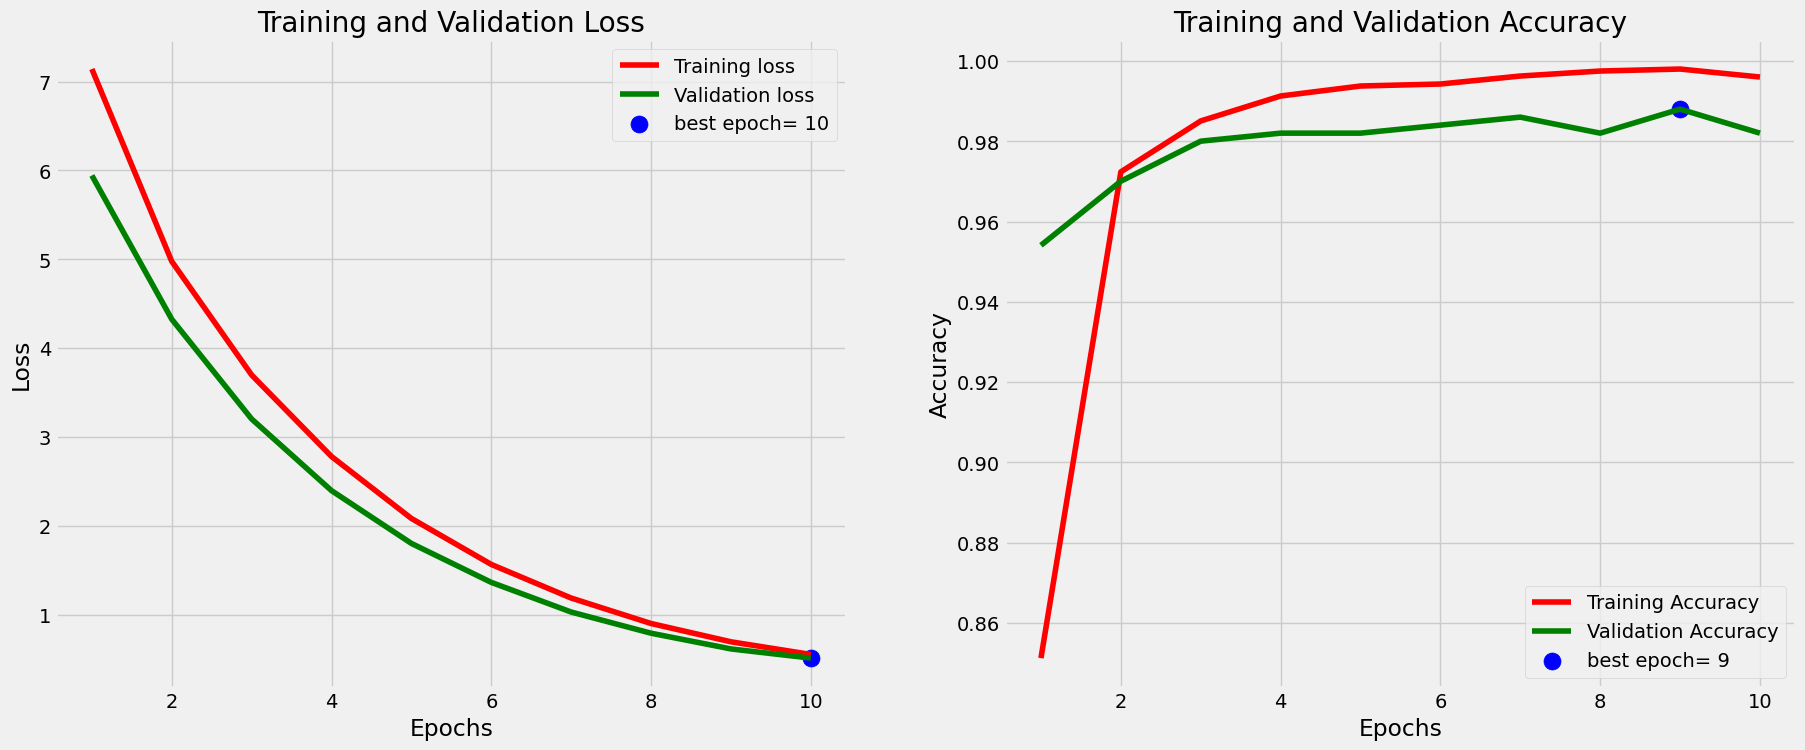

503/503 [==============================] - 7s 13ms/step - loss: 0.5009 - accuracy: 0.9841
accuracy on the test set is 98.41 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tr_plot(history,0)
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (255,255,255),(0,0,0))
model.save(" ")